### Live Expectancy (WHO) - linear regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV
from sklearn import metrics
import seaborn as sns
import scipy.stats as stats
import matplotlib.pylab as plt
import re

### Data preview

In [2]:
df = pd.read_csv('Life Expectancy Data.csv')
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
df = df.rename(columns=lambda x: x.strip()).rename(columns=lambda x: re.sub(r'\s+', '_', x))
df.columns

Index(['Country', 'Year', 'Status', 'Life_expectancy', 'Adult_Mortality',
       'infant_deaths', 'Alcohol', 'percentage_expenditure', 'Hepatitis_B',
       'Measles', 'BMI', 'under-five_deaths', 'Polio', 'Total_expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness_1-19_years',
       'thinness_5-9_years', 'Income_composition_of_resources', 'Schooling'],
      dtype='object')

Check data types:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life_expectancy                  2928 non-null   float64
 4   Adult_Mortality                  2928 non-null   float64
 5   infant_deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   Hepatitis_B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five_deaths                2938 non-null   int64  
 12  Polio               

### Missing values

In [5]:
df.isnull().sum() * 100 / len(df)

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life_expectancy                     0.340368
Adult_Mortality                     0.340368
infant_deaths                       0.000000
Alcohol                             6.603131
percentage_expenditure              0.000000
Hepatitis_B                        18.822328
Measles                             0.000000
BMI                                 1.157250
under-five_deaths                   0.000000
Polio                               0.646698
Total_expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
Population                         22.191967
thinness_1-19_years                 1.157250
thinness_5-9_years                  1.157250
Income_composition_of_resources     5.684139
Schooling                           5.547992
dtype: flo

Let's check correlation between dependent variable (Life_expectancy) and variables that have the most missing values.

In [6]:
df[['Life_expectancy', 'Hepatitis_B', 'GDP', 'Population']].corr()['Life_expectancy']

Life_expectancy    1.000000
Hepatitis_B        0.256762
GDP                0.461455
Population        -0.021538
Name: Life_expectancy, dtype: float64

We see that correlation between population and life expectancy is very low and it's the variable having the most missing values so we'll drop the column.

In [7]:
df.drop(columns=['Population'], inplace=True)

In [8]:
df.isnull().sum() * 100 / len(df)

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life_expectancy                     0.340368
Adult_Mortality                     0.340368
infant_deaths                       0.000000
Alcohol                             6.603131
percentage_expenditure              0.000000
Hepatitis_B                        18.822328
Measles                             0.000000
BMI                                 1.157250
under-five_deaths                   0.000000
Polio                               0.646698
Total_expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
thinness_1-19_years                 1.157250
thinness_5-9_years                  1.157250
Income_composition_of_resources     5.684139
Schooling                           5.547992
dtype: float64

In [9]:
missing_GDP_countries = df[df.GDP.isna()].Country.unique()
missing_GDP_countries

array(['Bahamas', 'Bolivia (Plurinational State of)', "Côte d'Ivoire",
       'Congo', 'Cook Islands', 'Czechia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Egypt', 'Eritrea', 'Gambia',
       'Iran (Islamic Republic of)', 'Iraq', 'Kyrgyzstan',
       "Lao People's Democratic Republic", 'Libya',
       'Micronesia (Federated States of)', 'Monaco', 'Niue',
       'Papua New Guinea', 'Republic of Korea', 'Republic of Moldova',
       'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'San Marino',
       'Sao Tome and Principe', 'Slovakia', 'Somalia', 'South Sudan',
       'Syrian Arab Republic',
       'The former Yugoslav republic of Macedonia',
       'United Kingdom of Great Britain and Northern Ireland',
       'United Republic of Tanzania', 'United States of America',
       'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Yemen'],
      dtype=object)

In [10]:
# check for values missing for every year
nan = df.set_index('Country').isnull().groupby('Country').all()
countries_missing_all_GDP = nan[nan.GDP==True].index

100*len(df[df.Country.isin(np.array(countries_missing_all_GDP))])/len(df[df.GDP.isna()])

90.40178571428571

We got that 90% of missing GDP is for the same country, so it means that we can not interpolate the data (it would't make sense to interpolate GDP of some country based on other country's data). So we'll remove all the rows with missing GDP (not the columns since correlation between GDP and life expectancy is moderately strong).

In [11]:
df.dropna(subset=['GDP'], axis=0, inplace=True)
df

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,under-five_deaths,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,83,6.0,8.16,65.0,0.1,584.259210,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,86,58.0,8.18,62.0,0.1,612.696514,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,89,62.0,8.13,64.0,0.1,631.744976,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,93,67.0,8.52,67.0,0.1,669.959000,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,97,68.0,7.87,68.0,0.1,63.537231,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,42,67.0,7.13,65.0,33.6,454.366654,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,41,7.0,6.52,68.0,36.7,453.351155,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,40,73.0,6.53,71.0,39.8,57.348340,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,39,76.0,6.16,75.0,42.1,548.587312,1.6,1.7,0.427,9.8


In [12]:
nan = df.set_index('Country').isnull().groupby('Country').all()
countries_missing_all_Hepatitis_B = nan[nan.Hepatitis_B==True].index
countries_missing_all_Hepatitis_B

Index(['Denmark', 'Finland', 'Hungary', 'Iceland', 'Japan', 'Norway',
       'Slovenia', 'Switzerland'],
      dtype='object', name='Country')

After doing some research we found out that:

_"Six countries have not yet introduced universal immunization against hepatitis B: Denmark, Finland, Iceland, Norway, Sweden and United Kingdom. They have very low endemicity and consider hepatitis B to be a limited public health problem, thus not justifying additional expense. They provide hepatitis B vaccine only to well-defined risk groups, in addition to screening pregnant women to identify and immunize neonates exposed to infection. This policy is unlikely to affect the circulation of the hepatitis B virus or to control the disease in those countries."_ (WHO)

Common sense dictates that higher Hepatitis B immunization coverage indicates higher life expectancy. So for the countries where there's no data because "they have very low endemicity" we can assume that life expectancy related to the Hepatitis B is high, therefore for those countries we choose to interpolate the value to the max value.

In [13]:
low_hepatitis_B_epidemicity_countries = ['Denmark', 'Finland', 'Iceland', 'Norway']
mask = df.Country.isin(low_hepatitis_B_epidemicity_countries)
hepatitis_B_max = df.Hepatitis_B.max()
df.loc[mask, 'Hepatitis_B'] = df.loc[mask, 'Hepatitis_B'].fillna(hepatitis_B_max)
df

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,under-five_deaths,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,83,6.0,8.16,65.0,0.1,584.259210,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,86,58.0,8.18,62.0,0.1,612.696514,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,89,62.0,8.13,64.0,0.1,631.744976,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,93,67.0,8.52,67.0,0.1,669.959000,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,97,68.0,7.87,68.0,0.1,63.537231,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,42,67.0,7.13,65.0,33.6,454.366654,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,41,7.0,6.52,68.0,36.7,453.351155,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,40,73.0,6.53,71.0,39.8,57.348340,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,39,76.0,6.16,75.0,42.1,548.587312,1.6,1.7,0.427,9.8


For other missing values we'll use linear interpolation (grouping data by country first) since our data is time series.

In [14]:
df = df.groupby('Country').apply(lambda group: group.interpolate(method='linear', limit_direction='backward'))

In [15]:
df.isnull().sum() * 100 / len(df)

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life_expectancy                     0.200803
Adult_Mortality                     0.200803
infant_deaths                       0.000000
Alcohol                             0.361446
percentage_expenditure              0.000000
Hepatitis_B                        16.546185
Measles                             0.000000
BMI                                 0.963855
under-five_deaths                   0.000000
Polio                               0.441767
Total_expenditure                   0.281124
Diphtheria                          0.441767
HIV/AIDS                            0.000000
GDP                                 0.000000
thinness_1-19_years                 0.963855
thinness_5-9_years                  0.963855
Income_composition_of_resources     0.240964
Schooling                           0.120482
dtype: float64

Finally we remove all remaining missing values.

In [17]:
df.dropna(inplace=True)

In [18]:
df.isna().sum()

Country                            0
Year                               0
Status                             0
Life_expectancy                    0
Adult_Mortality                    0
infant_deaths                      0
Alcohol                            0
percentage_expenditure             0
Hepatitis_B                        0
Measles                            0
BMI                                0
under-five_deaths                  0
Polio                              0
Total_expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
thinness_1-19_years                0
thinness_5-9_years                 0
Income_composition_of_resources    0
Schooling                          0
dtype: int64

### Multicollinearity

In [19]:
corr = df.corr()
corr

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,under-five_deaths,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
Year,1.000000,0.048366,-0.024682,0.008787,-0.112795,0.006868,0.088453,-0.042953,0.008512,0.010262,-0.033401,0.067593,0.023069,-0.114900,0.071795,0.014521,0.012321,0.127100,0.096492
Life_expectancy,0.048366,1.000000,-0.717828,-0.190202,0.376140,0.405262,0.255554,-0.087917,0.528956,-0.212456,0.358189,0.163816,0.353115,-0.579743,0.449638,-0.468844,-0.472094,0.714079,0.728794
Adult_Mortality,-0.024682,-0.717828,1.000000,0.070425,-0.153774,-0.244086,-0.155373,0.018075,-0.362483,0.087838,-0.233337,-0.061234,-0.213546,0.548583,-0.285179,0.278189,0.294876,-0.473413,-0.445157
infant_deaths,0.008787,-0.190202,0.070425,1.000000,-0.097937,-0.092865,-0.233615,0.551364,-0.231876,0.996752,-0.164558,-0.123810,-0.163852,0.019952,-0.108623,0.465704,0.465460,-0.146661,-0.217639
Alcohol,-0.112795,0.376140,-0.153774,-0.097937,1.000000,0.357379,0.091894,-0.045189,0.311783,-0.093772,0.203566,0.291616,0.199406,-0.023706,0.314981,-0.414443,-0.397047,0.446105,0.555894
percentage_expenditure,0.006868,0.405262,-0.244086,-0.092865,0.357379,1.000000,0.058756,-0.066410,0.238954,-0.094160,0.129638,0.167713,0.117101,-0.097306,0.893715,-0.257705,-0.260749,0.390339,0.413787
Hepatitis_B,0.088453,0.255554,-0.155373,-0.233615,0.091894,0.058756,1.000000,-0.126471,0.163332,-0.243177,0.475616,0.076021,0.610119,-0.118500,0.108772,-0.130048,-0.139949,0.216095,0.244813
Measles,-0.042953,-0.087917,0.018075,0.551364,-0.045189,-0.066410,-0.126471,1.000000,-0.153722,0.534384,-0.065880,-0.094427,-0.061532,0.005205,-0.076399,0.196355,0.191788,-0.071850,-0.122508
BMI,0.008512,0.528956,-0.362483,-0.231876,0.311783,0.238954,0.163332,-0.153722,1.000000,-0.239257,0.204789,0.154478,0.187950,-0.212576,0.283814,-0.511080,-0.520643,0.497741,0.539087
under-five_deaths,0.010262,-0.212456,0.087838,0.996752,-0.093772,-0.094160,-0.243177,0.534384,-0.239257,1.000000,-0.178611,-0.122843,-0.179925,0.031856,-0.110689,0.465970,0.464746,-0.159028,-0.228488


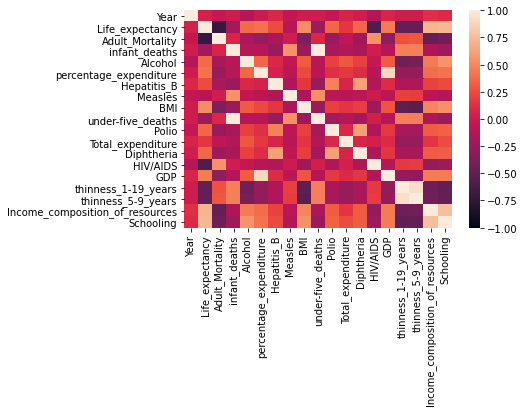

In [20]:
heatmap = sns.heatmap(corr, vmax=1, vmin=-1)

Looking at the heatmap and correlation matrix we look for highly correlated features and choose to keep features with higher correlation to the live expectancy (dependent variable):

- 'under-five deaths' and 'infant deaths' (corr=0.996752) - keeping 'under-five deaths';

- 'thiness 1-19 years' and 'thiness 5-9' (corr=0.933214) - keeping 'thinness 5-9 years';

- 'GDP' and 'percentage expenditure' (corr=0.893715) - keeping 'GDP';

- 'income composition of resources' and 'Schooling' (corr=0.770760) - keeping 'Schooling';

In [21]:
columns_to_drop = ['infant_deaths', 'thinness_5-9_years', 'percentage_expenditure', 'Income_composition_of_resources']
df.drop(columns=columns_to_drop, inplace=True)
df

,Country,Year,Status,Life_expectancy,Adult_Mortality,Alcohol,Hepatitis_B,Measles,BMI,under-five_deaths,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,thinness_1-19_years,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,0.01,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,17.2,10.1
1,Afghanistan,2014,Developing,59.9,271.0,0.01,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,17.5,10.0
2,Afghanistan,2013,Developing,59.9,268.0,0.01,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,17.7,9.9
3,Afghanistan,2012,Developing,59.5,272.0,0.01,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,17.9,9.8
4,Afghanistan,2011,Developing,59.2,275.0,0.01,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,18.2,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,4.36,68.0,31,27.1,42,67.0,7.13,65.0,33.6,454.366654,9.4,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,4.06,7.0,998,26.7,41,7.0,6.52,68.0,36.7,453.351155,9.8,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,4.43,73.0,304,26.3,40,73.0,6.53,71.0,39.8,57.348340,1.2,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,1.72,76.0,529,25.9,39,76.0,6.16,75.0,42.1,548.587312,1.6,9.8


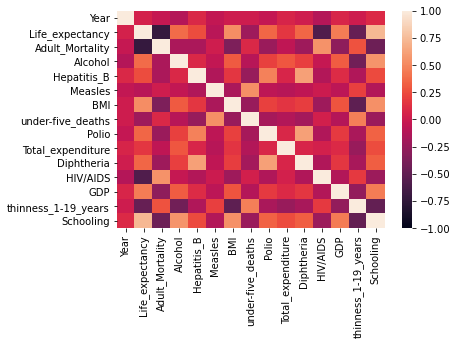

In [22]:
corr = df.corr()
heatmap = sns.heatmap(corr, vmax=1, vmin=-1)

### Categorical variables

Check whether status significantly affects live expectancy.

In [23]:
pd.DataFrame(df.groupby('Status').Life_expectancy.mean())

,Life_expectancy
Status,
Developed,79.369208
Developing,68.697146


We see that there's a difference between values, but is it significant? In order to find out we need to calculate p-value.

(array([14., 29., 22., 25., 77., 67., 70., 11., 13., 13.]),
 array([69.9 , 71.81, 73.72, 75.63, 77.54, 79.45, 81.36, 83.27, 85.18,
        87.09, 89.  ]),
 <BarContainer object of 10 artists>)

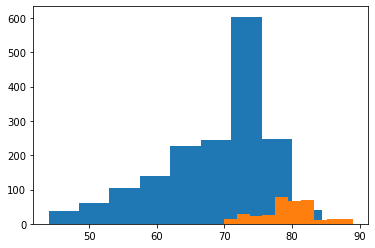

In [24]:
# Visual check for normality
plt.hist(df[df.Status=='Developing'].Life_expectancy)
plt.hist(df[df.Status=='Developed'].Life_expectancy)

In [25]:
developed_life_exp = df[df.Status=='Developed'].Life_expectancy
developing_life_exp = df[df.Status=='Developing'].Life_expectancy

stats.ttest_ind(developed_life_exp, developing_life_exp).pvalue

2.2983179486468938e-107

Since p-value is much less than 0.05 it means that difference between developed and developing countries' life expectancy is significant. Therefore we should include status in our model.

In [26]:
df = pd.get_dummies(df, columns=['Status'])
df

,Country,Year,Life_expectancy,Adult_Mortality,Alcohol,Hepatitis_B,Measles,BMI,under-five_deaths,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,thinness_1-19_years,Schooling,Status_Developed,Status_Developing
0,Afghanistan,2015,65.0,263.0,0.01,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,17.2,10.1,0,1
1,Afghanistan,2014,59.9,271.0,0.01,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,17.5,10.0,0,1
2,Afghanistan,2013,59.9,268.0,0.01,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,17.7,9.9,0,1
3,Afghanistan,2012,59.5,272.0,0.01,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,17.9,9.8,0,1
4,Afghanistan,2011,59.2,275.0,0.01,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,18.2,9.5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,44.3,723.0,4.36,68.0,31,27.1,42,67.0,7.13,65.0,33.6,454.366654,9.4,9.2,0,1
2934,Zimbabwe,2003,44.5,715.0,4.06,7.0,998,26.7,41,7.0,6.52,68.0,36.7,453.351155,9.8,9.5,0,1
2935,Zimbabwe,2002,44.8,73.0,4.43,73.0,304,26.3,40,73.0,6.53,71.0,39.8,57.348340,1.2,10.0,0,1
2936,Zimbabwe,2001,45.3,686.0,1.72,76.0,529,25.9,39,76.0,6.16,75.0,42.1,548.587312,1.6,9.8,0,1


### Model selection, hypertuning

In [26]:
X = df.drop(columns=['Life_expectancy', 'Country'])
y = df.Life_expectancy

In [27]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

def train_test_validation_split(X, y, random_state = None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-train_ratio), random_state=random_state)
    test_size_validation = test_ratio/(test_ratio + validation_ratio)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_size_validation, random_state=random_state) 
    return X_train, X_test, X_val, y_train, y_test, y_val

In [28]:
space = dict()
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

ridge_space = space.copy()
ridge_space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']

neg_mse_scoring = 'neg_mean_squared_error'

def hypertune(model, params, X, y, scoring = neg_mse_scoring):
    search = GridSearchCV(model, params, scoring=scoring, n_jobs=-1)
    return search.fit(X, y)

def compare_models(models, spaces, scoring=neg_mse_scoring, splits=20, random_state=None):
    results = defaultdict(list)
    j=0;
    for i in range(0,splits):
        X_train, X_validate, X_test, y_train, y_validate, y_test = train_test_validation_split(X, y, random_state)
        for model, space in zip(models, spaces):
            result = hypertune(model, space, X_validate, y_validate, scoring)
            best_params = result.best_params_
            model_name = model.__class__.__name__
            model = model.set_params(**best_params)
            model.fit(X_train, y_train)
            predicted = model.predict(X_test)
            mse = metrics.mean_squared_error(y_test, predicted)
            alpha = best_params.get('alpha')
            solver = best_params.get('solver')
            results[j] = [model_name, mse, alpha, solver]
            j+=1
    return results

In [29]:
results = compare_models(
    models = [LinearRegression(), Ridge(), Lasso()], 
    spaces = [dict(), ridge_space, space],
    splits=5,
    random_state=42,
)

results_df = pd.DataFrame(results).T
results_df.columns = ['model','mse','alpha', 'solver']
results_df.mse = results_df.mse.astype('float64')
results_df

,model,mse,alpha,solver
0,LinearRegression,15.488802,None,None
1,Ridge,15.544977,100,cholesky
2,Lasso,15.792616,1,None
3,LinearRegression,15.488802,None,None
4,Ridge,15.544977,100,cholesky
5,Lasso,15.792616,1,None
6,LinearRegression,15.488802,None,None
7,Ridge,15.544977,100,cholesky
8,Lasso,15.792616,1,None
9,LinearRegression,15.488802,None,None


In [30]:
results_df.groupby('model').mean()

,mse
model,
Lasso,15.792616
LinearRegression,15.488802
Ridge,15.544977


In our case LinearRegression gives the best results (minimal mse). But the difference is small. We also noticed that for differemt data splits (i.e. different random_state values) the results also differ. This might be due to the relatively small dataset.